# What is torch.nn really?

From https://pytorch.org/tutorials/beginner/nn_tutorial.html?highlight=mnist.

First, let's download some datasets.

In [18]:
from pathlib import Path
import os
import requests

DATA_PATH = Path("../data/external")
PATH = DATA_PATH / "mnist"

# Good lord, SSL cert expired in 2013
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not(PATH / FILENAME).exists():
    try:
        os.mkdir(PATH)
    except FileExistsError:
        pass
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

Is it there?

In [19]:
!ls ../data/external/mnist
!file ../data/external/mnist/mnist.pkl.gz

mnist.pkl.gz
../data/external/mnist/mnist.pkl.gz: gzip compressed data, was "mnist.pkl", last modified: Thu Jan 14 17:32:04 2010, max compression, original size modulo 2^32 220080342


Good!

In [28]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    # I'm not sure why we're dropping the third item here.
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Let's look at a sample.

(50000, 784)


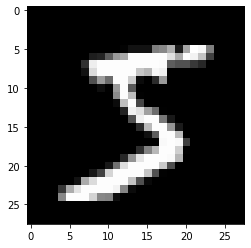

In [34]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape)

We need to convert this to tensors.

In [35]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

x_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

Now let's make a neural net from scratch, using nothing but PyTorch tensors & their operations.

- We're using Xavier initialization ([paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), [blog post explanation](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/)).
- We're setting gradients on weights *after* initialization, so that we don't track that in the gradients.  I guess that another way to do this would be to initialize them with gradients, then explicitly zero them afterward.

In [41]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Now let's write our activation function, `log_softmax()`, and create a model.

In [42]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

# TODO

- Understand why a 784 x 10 matrix is the right thing here....I have a hard time understanding how that gets reshaped into 784 inputs -> 10 outputs